In [96]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom, RandomContrast, RandomTranslation
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.applications import MobileNet, MobileNetV2

In [ ]:
# Directory Path

BASE_DIR = 'Dataset'
print(f"Base Directory: {os.listdir(BASE_DIR)}")

data_train='Dataset/train'
print(f"Data Directory: {os.listdir(data_train)}")

data_validation='Dataset/valid'
print(f"Data Directory: {os.listdir(data_validation)}")

Base Directory: ['train', 'valid']
Data Directory: ['Belimbing Sayur', 'Bunga Lawang', 'Jahe', 'Jeruk Nipis', 'Kunyit', 'Lengkuas', 'Mengkudu']
Data Directory: ['Belimbing Sayur', 'Bunga Lawang', 'Jahe', 'Jeruk Nipis', 'Kunyit', 'Lengkuas', 'Mengkudu']


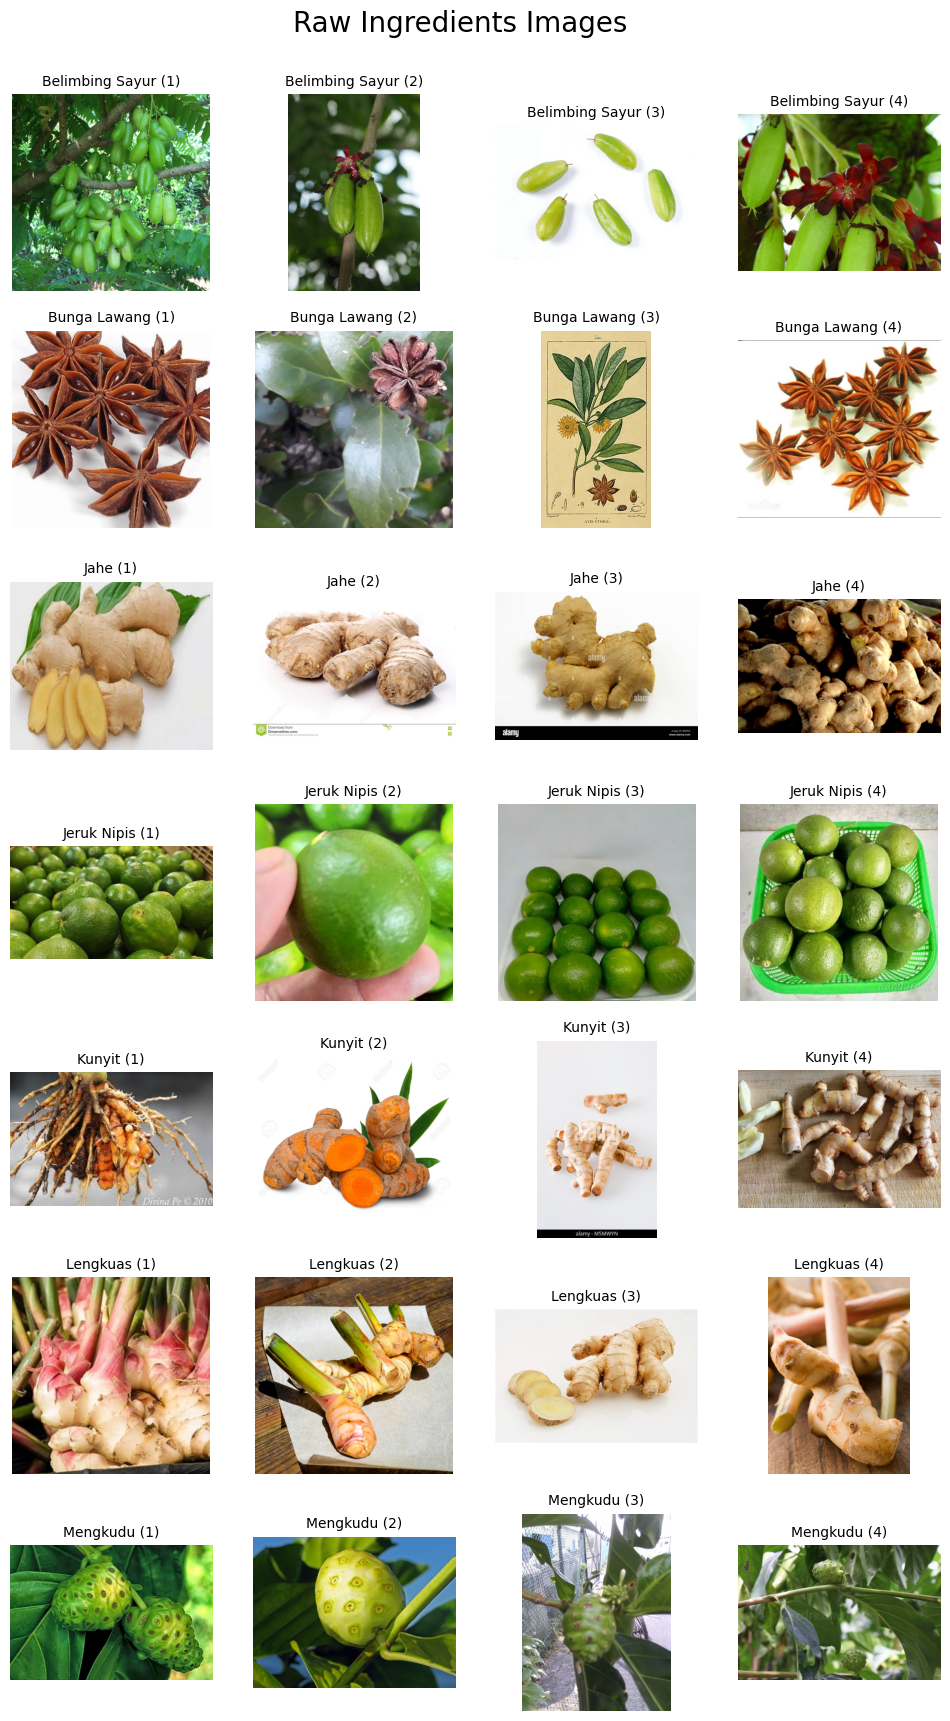

In [50]:
# List of class names
class_names = os.listdir(data_train)

# Create a grid with rows equal to number of classes and 4 columns
fig, axes = plt.subplots(len(class_names), 4, figsize=(12, len(class_names) * 3))
fig.suptitle('Raw Ingredients Images', fontsize=20, y=0.92)

# Plot 4 images for each class
for row, class_name in enumerate(class_names):
    class_dir = os.path.join(data_train, class_name)
    image_filenames = os.listdir(class_dir)[:4]  # Ambil 4 gambar pertama dari setiap kelas

    for col, image_filename in enumerate(image_filenames):
        img_path = os.path.join(class_dir, image_filename)
        img = tf.keras.utils.load_img(img_path)  # Load image
        axes[row, col].imshow(img)
        axes[row, col].set_title(f'{class_name} ({col + 1})', fontsize=10)
        axes[row, col].axis('off')


plt.subplots_adjust(top=0.88)  # Beri ruang untuk judul
plt.show()

In [53]:
BATCH_SIZE = 32
IMAGE_SIZE = (224, 224)
LABEL_MODE = 'categorical'

# Inisiasi Dataset
# Instantiate the training dataset
train_dataset = tf.keras.utils.image_dataset_from_directory(
    data_train,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    label_mode=LABEL_MODE
)

# Instantiate the validation dataset
validation_dataset = tf.keras.utils.image_dataset_from_directory(
    data_validation,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    label_mode=LABEL_MODE
)


Found 2055 files belonging to 7 classes.
AttributeError: module 'ml_dtypes' has no attribute 'float8_e3m4'
Found 487 files belonging to 7 classes.


In [ ]:
# FILL_MODE='reflect'
# # Membuat layer augmentasi data
# data_augmentation = tf.keras.Sequential([
#     tf.keras.Input(shape=(224, 224, 3)),
#     RandomFlip("horizontal"),# Membalik gambar secara horizontal
#     RandomRotation(0.2, fill_mode=FILL_MODE), # Rotasi gambar hingga 20%
#     RandomZoom(0.2, fill_mode=FILL_MODE),  # Zoom gambar hingga 20%
#     RandomContrast(0.2), # Mengubah kontras gambar hingga 20%
#     RandomTranslation(0.1, 0.1, fill_mode=FILL_MODE) # Translasi (geser) gambar hingga 10% horizontal dan vertikal
# ])


In [77]:
def train_val_generators(TRAINING_DIR, VALIDATION_DIR):

  # Instantiate the ImageDataGenerator class
  train_datagen = ImageDataGenerator(rescale=1.0/255.,
                                     rotation_range=40,
                                     width_shift_range=0.2,
                                     height_shift_range=0.2,
                                     shear_range=0.2,
                                     zoom_range=0.2,
                                     horizontal_flip=True,
                                     fill_mode='reflect')

  # Pass in the appropriate arguments to the flow_from_directory method
  train_generator = train_datagen.flow_from_directory(TRAINING_DIR,
                                                      batch_size=BATCH_SIZE,
                                                      class_mode=LABEL_MODE,
                                                      target_size=IMAGE_SIZE)

  # Instantiate the ImageDataGenerator
  validation_datagen = ImageDataGenerator(rescale=1.0/255.)

  # Pass in the appropriate arguments to the flow_from_directory method
  validation_generator = validation_datagen.flow_from_directory(VALIDATION_DIR,
                                                                batch_size=BATCH_SIZE,
                                                                class_mode=LABEL_MODE,
                                                                target_size=IMAGE_SIZE)

  return train_generator, validation_generator

In [84]:
train_generator, validation_generator = train_val_generators(data_train, data_validation)

Found 2055 images belonging to 7 classes.
Found 487 images belonging to 7 classes.


In [79]:
base_model = MobileNetV2(input_shape=(224, 224, 3), include_top=False)

for layer in base_model.layers:
  layer.trainable = False

In [80]:
def simple_model():
    model = tf.keras.models.Sequential([
        base_model,
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(7, activation='softmax')
    ])

    return model

In [81]:
model = simple_model()
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 62720)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │     8,028,288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 7)              │           455 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,294,983 (39.27 MB)

 Trainable params: 8,036,999 (30.66 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [86]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [87]:
# Callbacks
class EarlyStoppingCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        train_accuracy = logs.get('accuracy')
        val_accuracy = logs.get('val_accuracy')

        if train_accuracy >= 0.95 and val_accuracy >= 0.85:
            self.model.stop_training = True
            print("\nReached 95% train accuracy and 85% validation accuracy, so cancelling training!")


In [88]:
# Training model dengan data augmentasi
history = model.fit(
    train_generator,
    epochs=100,
    verbose=1,
    validation_data=validation_generator,
    callbacks=[EarlyStoppingCallback()]
)

c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100
60/65 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.4797 - loss: 3.5352

c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\PIL\Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


65/65 ━━━━━━━━━━━━━━━━━━━━ 109s 2s/step - accuracy: 0.4899 - loss: 3.4304 - val_accuracy: 0.8891 - val_loss: 0.3328
Epoch 2/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 78s 1s/step - accuracy: 0.7391 - loss: 0.9016 - val_accuracy: 0.9055 - val_loss: 0.2814
Epoch 3/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 63s 974ms/step - accuracy: 0.7841 - loss: 0.7554 - val_accuracy: 0.9055 - val_loss: 0.3021
Epoch 4/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 66s 1s/step - accuracy: 0.7818 - loss: 0.7282 - val_accuracy: 0.9281 - val_loss: 0.2391
Epoch 5/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 65s 1s/step - accuracy: 0.8272 - loss: 0.5545 - val_accuracy: 0.9302 - val_loss: 0.2329
Epoch 6/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 63s 975ms/step - accuracy: 0.8340 - loss: 0.5581 - val_accuracy: 0.9343 - val_loss: 0.2013
Epoch 7/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 64s 989ms/step - accuracy: 0.8828 - loss: 0.3849 - val_accuracy: 0.9363 - val_loss: 0.1820
Epoch 8/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 67s 1s/step - accuracy: 0.8706 - loss: 0.4498 - val_accuracy: 0.9281 - val

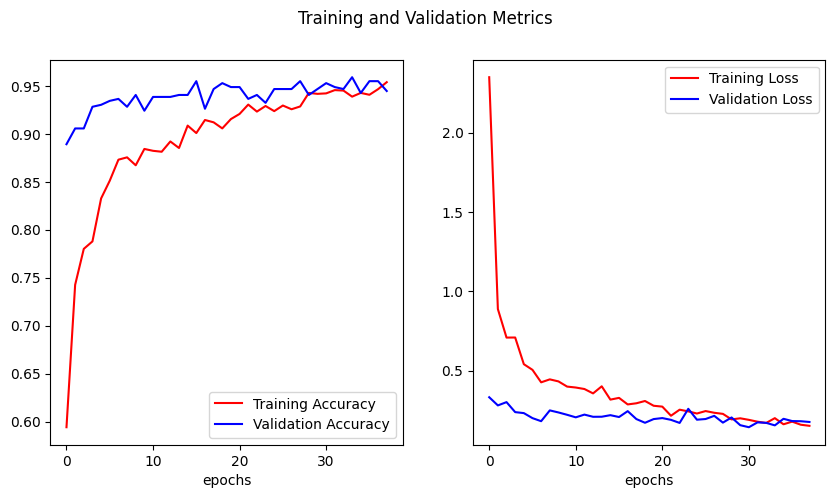

In [89]:
# Plot training and validation accuracy & loss
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

# Get number of epochs
epochs = range(len(acc))

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle('Training and Validation Metrics')

for i, (data, label) in enumerate(zip([(acc, val_acc), (loss, val_loss)], ["Accuracy", "Loss"])):
    ax[i].plot(epochs, data[0], 'r', label="Training " + label)
    ax[i].plot(epochs, data[1], 'b', label="Validation " + label)
    ax[i].legend()
    ax[i].set_xlabel('epochs')

plt.show()

16/16 ━━━━━━━━━━━━━━━━━━━━ 9s 514ms/step


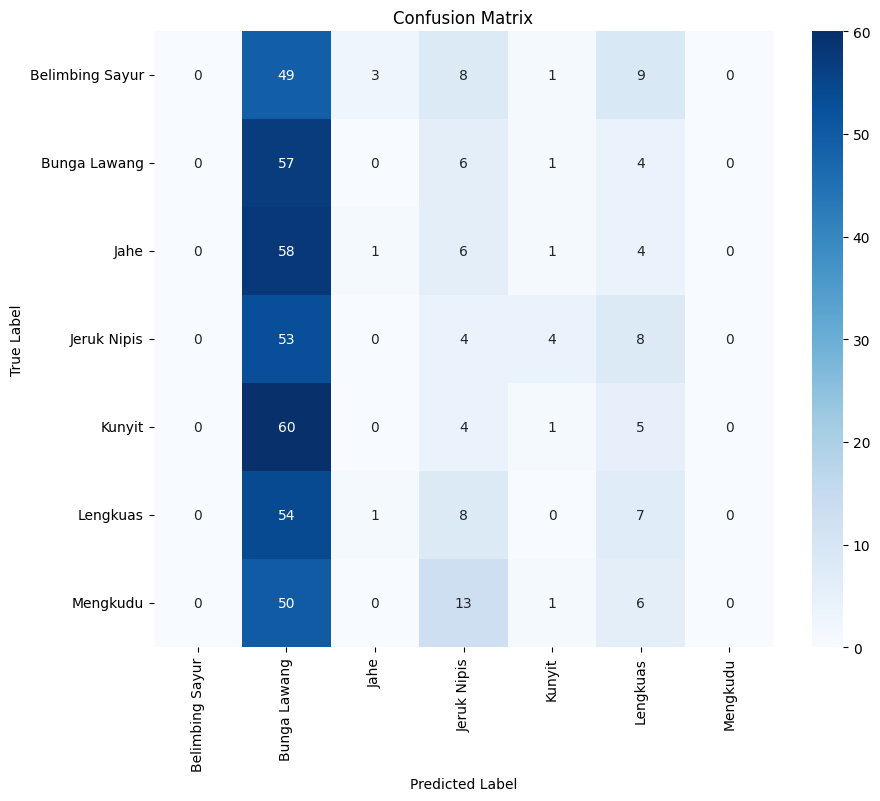

In [102]:
# Get true labels and predictions for the validation set
y_true = np.concatenate([y for x, y in validation_dataset], axis=0)
y_pred = model.predict(validation_dataset)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_true, axis=1)

# Create confusion matrix
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)

# Define function to plot confusion matrix
def plot_confusion_matrix(cm, class_names):
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.title('Confusion Matrix')
    plt.show()

# Plot the confusion matrix
class_names = os.listdir(data_train) # Labels for ingredients
plot_confusion_matrix(conf_matrix, class_names)

In [94]:
# Mendapatkan prediksi pada dataset validasi
y_pred = model.predict(validation_generator)
y_pred_classes = np.argmax(y_pred, axis=1)  # Konversi one-hot ke kelas

# Mendapatkan label asli
y_true = validation_generator.classes  # Label asli dari generator

# Mendapatkan nama kelas
class_names = list(validation_generator.class_indices.keys())


16/16 ━━━━━━━━━━━━━━━━━━━━ 11s 629ms/step


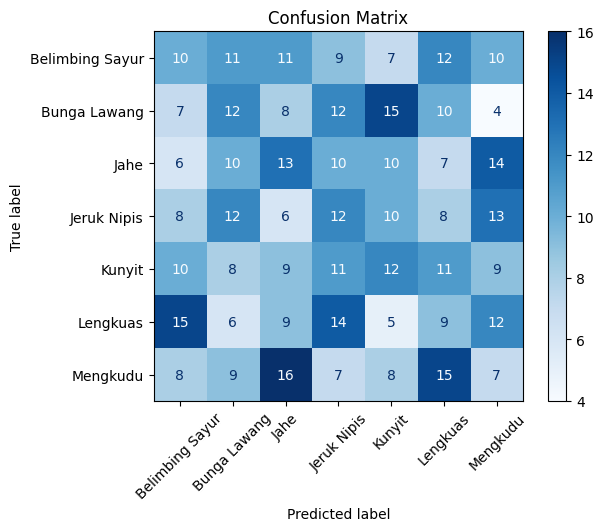

In [97]:
# Membuat confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)

# Menampilkan confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
plt.title('Confusion Matrix')
plt.show()
